## 一般化線形モデル　ロジスティック回帰のモデリング事例

In [131]:
# ライブラリ
import os
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
np.random.seed(111)
import random
random.seed(111)

# Data preprocessing library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scikit-learn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# graph
import matplotlib.pyplot as plt
import seaborn as sns

# scripts
import utils as u
# graph setting
u.graph_setting()

以下のscikit-learnのデータセットを用いる。<br>
タイタニックのデータセット

In [120]:
from sklearn.datasets import fetch_openml

# データセットの読み込み
titanic = fetch_openml('titanic', version=1, as_frame=True)

# データフレーム化
df = titanic.data
df["target"] = titanic.target

df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,target
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0


# データ確認

In [121]:
# 変数の情報確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
 13  target     1309 non-null   category
dtypes: category(3), float64(6), object(5)
memory usage: 116.8+ KB


### 各変数

説明変数<br>
1. pclass: 乗客のクラス（1=1st、2=2nd、3=3rd）
2. name: 乗客の名前
3. sex: 性別（maleまたはfemale）
4. age: 年齢
5. sibsp: 兄弟や配偶者の数
6. parch: 同乗していた親・子供の数
7. ticket: チケット番号
8. fare: 運賃
9. cabin: 客室番号
10. embarked: 乗船した港（C=Cherbourg、Q=Queenstown、S=Southampton)
11. boat: どの救命ボートに乗ったか
12. body: 遺体番号
13. home.dest: 各乗客が住んでいた故郷や行き先

目的変数<br>
- target: 死亡または生存を表す。（0=死亡、1=生存）

# データの前処理

### 取り除くもの
10, 11, 12は直接死亡か生存に関係がないので取り除く。

2. name: 乗客の名前
　名前自体から生存確率に関してうかがい知ることはできないが、名前の中にMissやMrといった情報がある。<br>
　性別や家族構成等の情報があるため、取り除く。<br>

6. ticket: チケット番号
  チケット番号の種類は929種類あり、全体の71%にもわたる。変数の数が多くなりすぎるため、取り除く。<br>

### ワンホットエンコーディングするもの

1. pclass: 乗客のクラス（1=1st、2=2nd、3=3rd）<br>
  クラス値の大小の意味に関する情報がない。<br>
  個の大小関係は生存死亡に関連性はなく、区別のみ関連があるとする。<br>

3. sex: 性別（maleまたはfemale）
  クラス値の大小の意味に関する情報がない。<br>
  個の大小関係は生存死亡に関連性はなく、区別のみ関連があるとする。<br>

8. cabin: 客室番号
  先頭アルファベットに、数字の組み合わせとなっている。<br>
  アルファベット部分は、船のどの位置なのか？という情報を含んでいる可能性があり、文字を切り取りこの部分のみ利用する。
  ただし、このデータは欠損値が多い。欠損は、個別の客室無の場合と仮説を立て、別のカテゴリを当てる。

9. embarked: 乗船した港（C=Cherbourg、Q=Queenstown、S=Southampton)
  各クラスにカテゴリ変数をあてる。

## その他に関しては、連続変数として扱う。

# データ前処理

In [122]:
# Initialize dataframe
df_ = pd.DataFrame({})

# pclass
df_ = pd.concat([df_, pd.get_dummies(["pc_" + str(p) for p in df.pclass])], axis=1)

# sex
df_ = pd.concat([df_, pd.get_dummies(df.sex)], axis=1)

# age
df_["age"] = df["age"].fillna(df["age"].mean()) # nan is filled by mean

# sibsp
df_["sibsp"] = df["sibsp"].fillna(0) # nan is filled by zero

# parch
df_["parch"] = df["parch"].fillna(0) # nan is filled by zero

# fare
df_["fare"] = df["fare"].fillna(df["fare"].mean()) # nan is filled by mean

# cabin
cabin = df.cabin.fillna("z")
cabin = ["cab_" + c[0] for c in cabin]
df_ = pd.concat([df_, pd.get_dummies(cabin)], axis=1)

# embarked
df_ = pd.concat([df_, pd.get_dummies(["em_" + str(e) for e in df.embarked])], axis=1)

# target
df_["target"] = df["target"].astype("int")

In [124]:
# データの分割
X = df_.iloc[:,:-1]
y = df_.iloc[:,-1]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 正規化
#sc = StandardScaler()
sc = MinMaxScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# モデリングの問題設定

目的変数 : target<br>
説明変数 : その他の変数<br>

# モデルの仮定

### targetのデータの特徴
- 0 or 1の2値

### よってロジスティック回帰でモデリングを行う。

- ロジスティック回帰モデル<br>
  応答変数が2値の場合に使用される。リンク関数にはロジット関数を使用し、分布族は二項分布を仮定する<br>
  
  モデル式<br>
  $\ln\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p$
  
  解法<br>
  最尤推定法<br>
  
  尤度関数<br>
  $L(\beta) = \prod_{i=1}^{n}p_i^{y_i}(1-p_i)^{1-y_i}$

### scikit-learnで構築

In [125]:
# ロジスティック回帰モデルの構築
# Logistic Regression
lr = LogisticRegression()

param_range = [0.001, 0.01, 0.1, 1.0]
penalty = ['none', 'l2']
param_grid = [{"C":param_range, "penalty":penalty}]

gs_lr = GridSearchCV(estimator=lr, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
gs_lr = gs_lr.fit(X_train_std, y_train)

print(gs_lr.best_score_.round(3))
print(gs_lr.best_params_)

0.794
{'C': 0.01, 'penalty': 'l2'}


In [126]:
# best model
lr = LogisticRegression(C=0.01, penalty="l2")

# fit
lr.fit(X_train_std, y_train)

LogisticRegression(C=0.01)

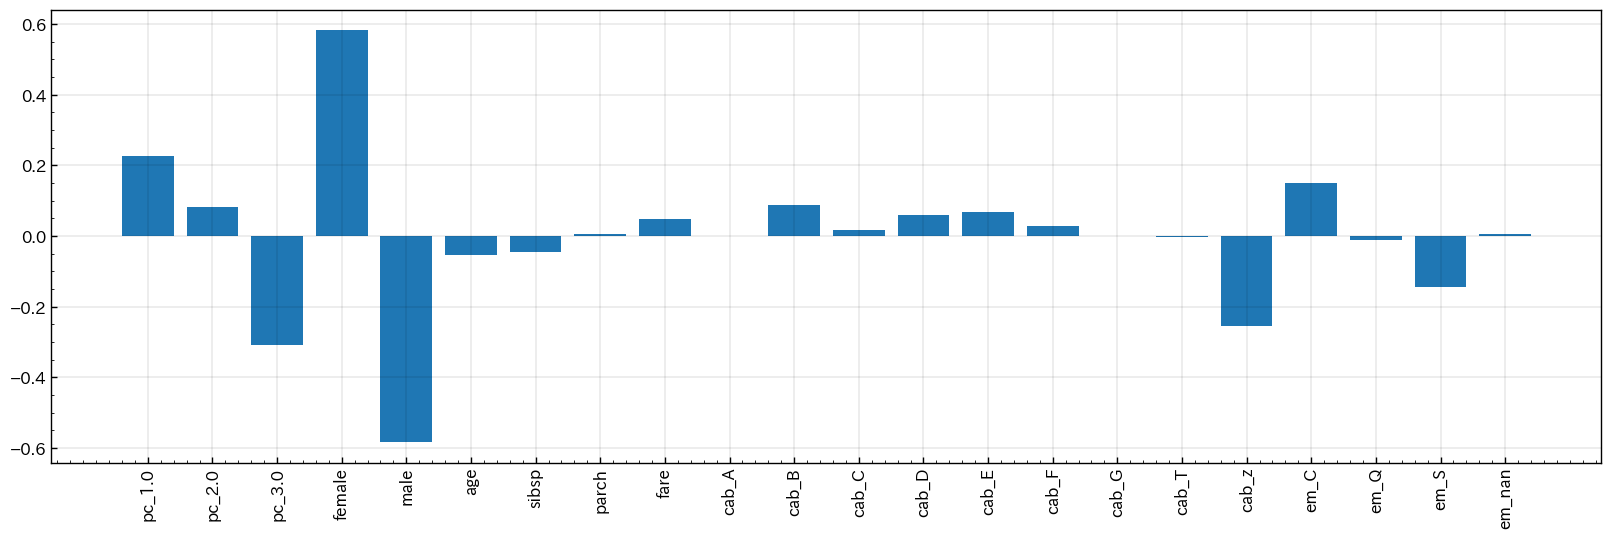

In [127]:
# feature names
fn = X.columns

coef_df = pd.DataFrame({
    "feature_names":fn,
    "coef":lr.coef_.reshape(-1,)
})

# plot
plt.figure(figsize=(20,6))
plt.bar(coef_df["feature_names"], coef_df["coef"])
plt.xticks(rotation=90);

### モデルの解釈
pclass : classが1が、生存確率が高い<br>
sex : femaleが、生存確率が高い。<br>
age : 年齢は低いほど生存確率が高い<br>
sibsp : 兄弟や配偶者は少ないほど生存確率が高い<br>
parch : あまり重要ではない。<br>
fare : 料金は高いほどわずかに生存確率が高い。<br>
cabin : Z(欠損値)が低い。その他はB, D, E, Fが高い<br>
embarked : Cherbourgが生存確率が高い。<br>

### 考察
係数を見ても、ある程度推測が立つ。<br>
例えば、pclassは1のクラスが脱出しやすい場所に客室があったのかもしれない。<br>
femaleが特に重要で、女性を優先的に脱出させていたのかもしれない。<br>
年齢は、若いほど脱出する体力があったのかもしれない。<br>
兄弟や配偶者の数は、単身の方が身軽で脱出に向う事ができたのかもしれない。<br>
cabinは部屋の位置が脱出しやすい場所かどうかが重要であったかもしれない。<br>
emberkedは、それにより客室の細かい場所が決められたのかもしれない<br>

ただ、いずれの場合も推測であるため、事実関係の確認は必要になる。

# 予測結果の確認

In [138]:
def draw_learning_curve(estimator, X_train, y_train):
    # learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1,10), cv=10, n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # plot
    plt.figure(figsize=(10,6))
    # train data
    plt.plot(train_sizes, train_mean, color="blue", marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, color="blue", alpha=0.15)
    # val data
    plt.plot(train_sizes, test_mean, color="green", marker='s', linestyle='--', markersize=5, label='validation accuracy')
    plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, color="green", alpha=0.15)

    plt.xlabel("Number of trainig samples")
    plt.ylabel("Accuracy")
    plt.ylim([0.2,1.0])
    plt.title("Learning curve")
    plt.legend()

In [128]:
def confmat_roccurve(X_test, y_test, estimator):
    # prediction
    y_pred = estimator.predict(X_test)
    # create confusion matrix
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    # visualiazation confusion matrix
    fig, ax = plt.subplots(1,2,figsize=(18,6))

    ax[0].matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax[0].text(x=j, y=i, s=confmat[i,j], va="center", ha="center")

    ax[0].set_xlabel("predicted label")
    ax[0].set_ylabel("true label")
    ax[0].set_title("confusion matrix")
    # Score
    print("accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
    print("precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
    print("recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
    print("f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

    # visualization roc curve
    y_score = estimator.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)
    ax[1].plot(fpr, tpr, label="roc curve (area = %.3f)" % auc(fpr, tpr), color="blue")
    ax[1].plot([0,1], [0,1], linestyle='--', color=(0.6,0.6,0.6), label='random')
    ax[1].plot([0,0,1], [0,1,1], linestyle=':', color="black", label='perfect performance')
    ax[1].set_xlabel("false positive rate")
    ax[1].set_ylabel("true positive rate")
    ax[1].set_title("Receiver Operator Characteristic")
    ax[1].legend()

学習曲線の確認

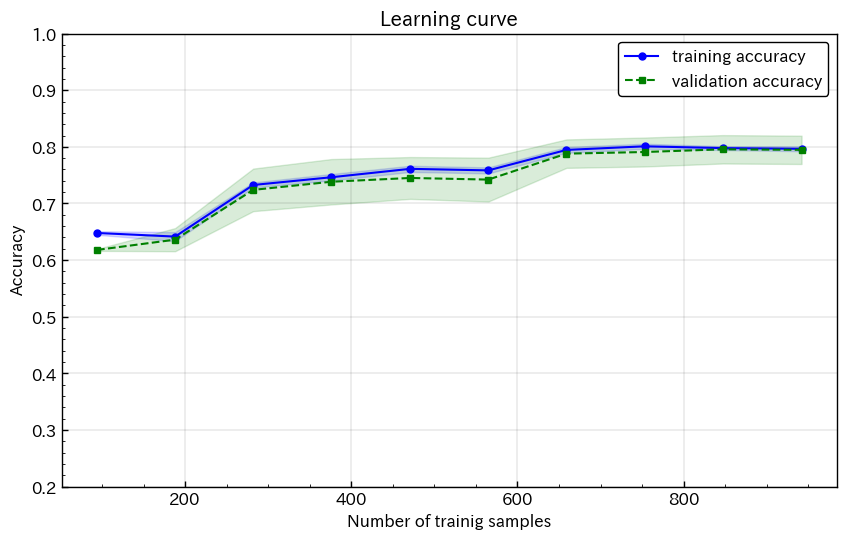

In [139]:
draw_learning_curve(estimator=lr, X_train=X_train_std, y_train=y_train)

混同行列の確認

学習データへのフィッティング

accuracy = 0.798
precision = 0.895
recall = 0.535
f1_score = 0.670


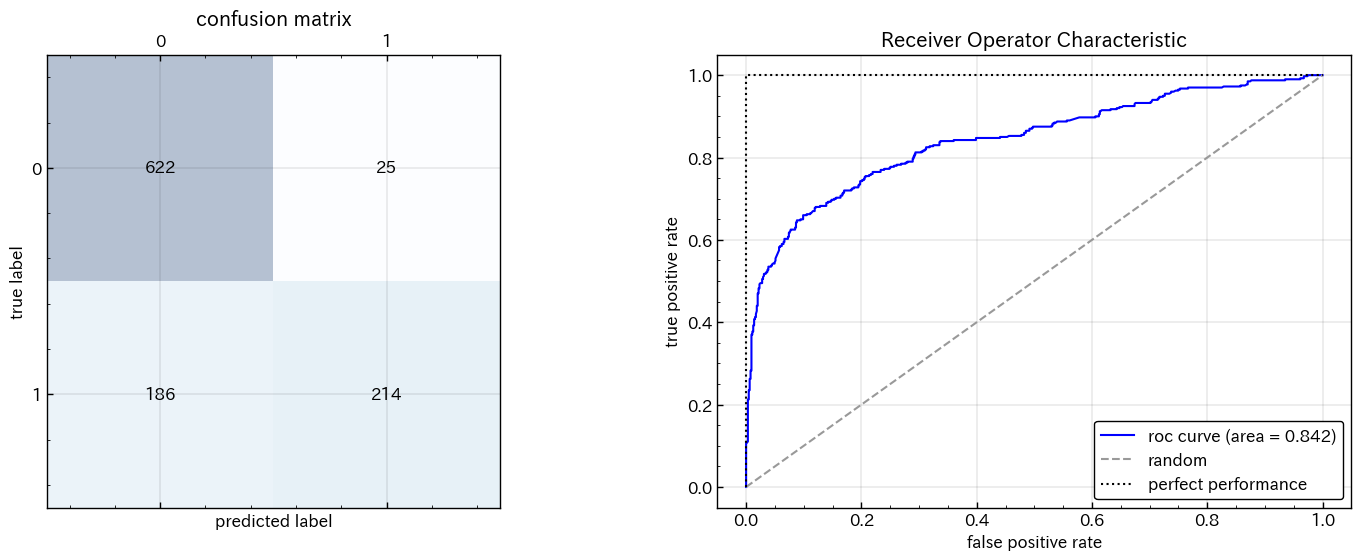

In [130]:
confmat_roccurve(X_test=X_train_std, y_test=y_train, estimator=lr)

評価データへのフィッティング

accuracy = 0.790
precision = 0.941
recall = 0.480
f1_score = 0.636


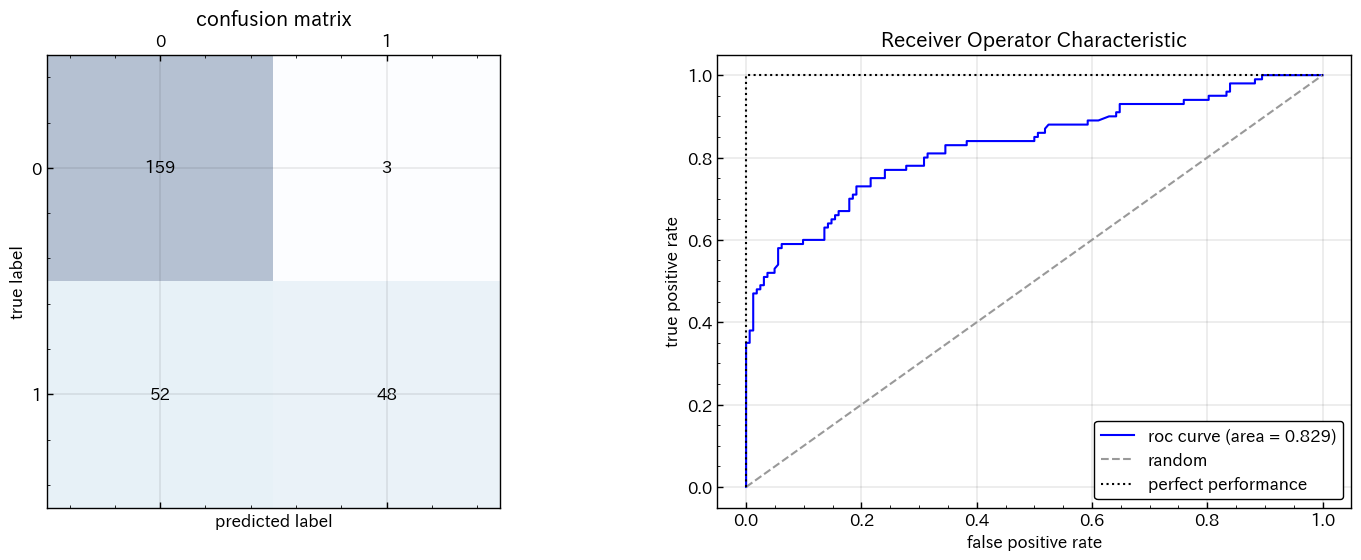

In [129]:
confmat_roccurve(X_test=X_test_std, y_test=y_test, estimator=lr)

### モデルの評価

- モデルは学習データと評価データで大きな乖離は無く、過学習の程度は低い。
- 精度面は、分類精度79%, 正確性が94%で良い数値が出ている。しかし、再現率が50%程と低い。
- 再現率を上げるためには、線形モデル以外のモデルも試す必要があり。